In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from statannot import add_stat_annotation
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from sklearn.linear_model import HuberRegressor
from collections import Counter

# Load sample metadata and count table

In [2]:
# read sample meta data and eliminate samples without transplant day
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab_asv =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab_asv.index))
df_sample = df_sample.loc[common_samples]
df_relab_asv = df_relab_asv.loc[common_samples]

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_96007/882759708.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_96007/882759708.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_sample = df_sample.loc[common_samples]
/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_96007/882759708.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_relab_asv = df_relab_asv.loc[common_samples]


In [3]:
len(set(df_sample.PatientID))

1276

# Compute oral percentage and qPCR

In [4]:
# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab_asv[set(df_blast_100.query_accver).intersection(df_relab_asv.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total = df_oral_total.reset_index('SampleID').sort_values(['OralFrac_HMPv35oral','SampleID']).set_index('SampleID')
df_oral_total['log10_OralFrac_HMPv35oral'] = np.log10(df_oral_total['OralFrac_HMPv35oral'])

# read qPCR data
df_qpcr=pd.read_csv('tblqpcr.csv', index_col=0)
df_qpcr = df_qpcr[df_qpcr.qPCR16S>0]
df_qpcr['log10_qPCR16S'] = np.log10(df_qpcr.qPCR16S)

# joint sample, oral fraction and qpcr
df = pd.merge(df_oral_total, df_qpcr, left_index=True, right_index=True, how='inner')
df = pd.merge(df, df_sample, left_index=True, right_index=True, how='inner')
df = df[df.OralFrac_HMPv35oral>0]
df.head()

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_96007/3313120001.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_oral_total = df_relab_asv[set(df_blast_100.query_accver).intersection(df_relab_asv.columns)].sum(axis=1).to_frame()
/Users/liaoc/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OralFrac_HMPv35oral,log10_OralFrac_HMPv35oral,qPCR16S,log10_qPCR16S,PatientID,Timepoint,Consistency,Accession,BioProject,DayRelativeToNearestHCT
SampleID,,,,,,,,,,
FMT.0106M,0.000060,-4.219279,1.080924e+08,8.033795,FMT.0106,28,liquid,SRR11421877,PRJNA545312,13.0
2163I,0.000070,-4.153200,2.594621e+07,7.414074,2163,11,liquid,SRR11117148,PRJNA607574,8.0
2163J,0.000098,-4.008491,6.648320e+06,6.822712,2163,15,liquid,SRR11117147,PRJNA607574,12.0
1842Q,0.000108,-3.967548,1.054196e+06,6.022921,1842,36,formed,SRR11115175,PRJNA607574,29.0
1842P,0.000111,-3.956350,6.300635e+04,4.799384,1842,35,liquid,SRR11115176,PRJNA607574,28.0


In [5]:
len(df)

3094

In [6]:
len(df[df.qPCR16S>=1e3])

3055

# Plot correlation between oral fraction and qPCR

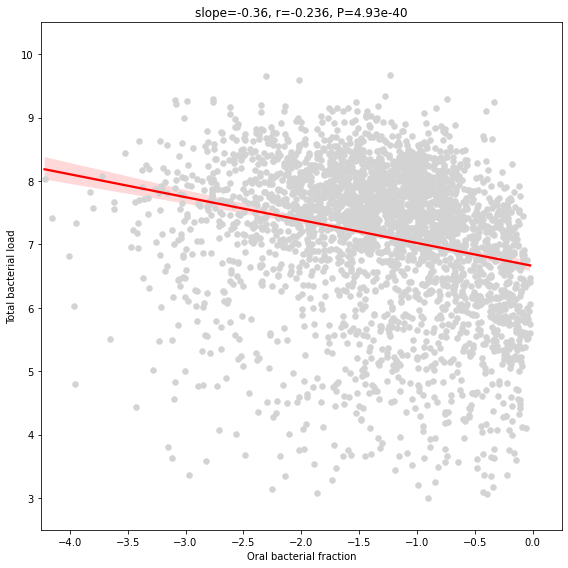

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

df = df[df.qPCR16S>=1e3]
_ = sns.regplot(data=df, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, scatter_kws={"color": "black"}, line_kws={"color": "red"}, scatter=False)
_ = sns.scatterplot(data=df, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, color='lightgray', edgecolor='lightgray')
_ = ax.set_ylabel('Total bacterial load')
_ = ax.set_xlabel('Oral bacterial fraction')
slope, intercept, r_value, p_value, std_err = stats.linregress(df.log10_OralFrac_HMPv35oral, df.log10_qPCR16S)
_ = ax.set_title('slope=%2.2f, r=%2.3f, P=%2.2e'%(slope, r_value, p_value))
_ = ax.set_xlim([-4.25, 0.25])
_ = ax.set_ylim([2.5,10.5])
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_oralfrac_qpcr_msk.png", dpi=600)
fig.savefig("correlation_oralfrac_qpcr_msk.svg", dpi=600)

# Binned distribution

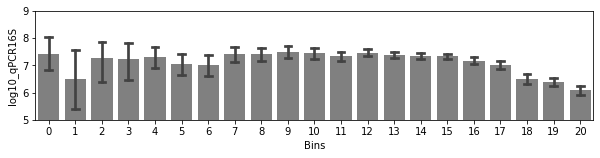

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2))

# calculate binned values
bins = np.linspace(-4,0,21)
digitized = np.digitize(list(df.log10_OralFrac_HMPv35oral), bins)
df['Bins']=digitized

# plot
_ = sns.barplot(x='Bins', y='log10_qPCR16S', data=df, ax=ax, color='grey', capsize=0.25)
_ = ax.set_ylim([5,9])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("binned_barplot_oral_qpcr.svg")